In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from datetime import datetime

## Andmed

In [18]:
hommik = 21_600  # hommikune äratus kell 06:00
reservaeg = 60_300  # tavaline reservaja algus kell 16:45
esimene_päev = 197  # teenistuse esimene päev 17.07.2023
söögigraafik_nädalaid = 6  # söögigraafiku nädalate arv

In [21]:
spioon_df = pd.read_csv('andmed/spioonid.csv')

spioon_df['kuupäev'] = spioon_df['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
spioon_df['sekund'] = spioon_df['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds())
spioon_df['päev'] = spioon_df['kuupäev'].apply(lambda x: x.timetuple().tm_yday - esimene_päev)  
spioon_df['päev_n'] = spioon_df.groupby('päev').cumcount()
spioon_df['päev_tühemik'] = spioon_df.groupby('päev')['sekund'].diff().fillna(spioon_df['sekund'] - hommik)
spioon_df['söögigraafik_nädal'] = spioon_df['kuupäev'].apply(lambda x: datetime.isocalendar(x).week % söögigraafik_nädalaid)
spioon_df['tegevusaeg'] = (spioon_df['sekund'] >= reservaeg).map({True: 'Vaba- ja reservaeg', False:'Muu aeg'})

# TODO reservaja andmepunktide jaoks peavad esimesed tühemikud algama 60300 (vist, peab poissoni protsessi üle uurima)

spioon_df.tail()

,kuupäev,sekund,päev,päev_n,päev_tühemik,söögigraafik_nädal,tegevusaeg
46,2023-08-09 20:22:37,73357.0,24,3,10185.0,2,Vaba- ja reservaeg
47,2023-08-09 21:06:34,75994.0,24,4,2637.0,2,Vaba- ja reservaeg
48,2023-08-09 21:11:45,76305.0,24,5,311.0,2,Vaba- ja reservaeg
49,2023-08-09 21:34:42,77682.0,24,6,1377.0,2,Vaba- ja reservaeg
50,2023-08-10 06:41:22,24082.0,25,0,2482.0,2,Muu aeg


### Intensiivsuse hinnang

Mittehomogeense Poissoni protsessi intensiivsue hinnang
\begin{equation*}
    \hat{\lambda}(t) =
    \begin{cases}
        \hat{\lambda}_1 , &t < 60 300 \\
        \hat{\lambda}_2 , &t \geq 60 300 \\
    \end{cases}
    \enspace .
\end{equation*}

Hinnangu kummalegi tinigmusele vastavale intensiivsusele saame valimikeskmise pöördväärtusest
\begin{equation*}
    \hat{\lambda}_j = \left( \frac{1}{n_j} \sum_{i = 1}^{n} x_{ji} \right)^{-1} \enspace ,
\end{equation*}
kus $n_j$ on vastava hinnangu tingliku valimi suurus ning $x_{ji}$ selle tingliku valimi $i$-s tühemik.

In [86]:
beta_1, beta_2 = spioon_df.groupby('tegevusaeg')['päev_tühemik'].mean()

print('eksponentjaotuse skaalaparameetrite hinnangud')
print(f'muu aeg:\t\t{beta_1:.2f}')
print(f'vaba- ja reservaeg:\t{beta_2:.2f}')

eksponentjaotuse skaalaparameetrite hinnangud
muu aeg:		17063.33
vaba- ja reservaeg:	15469.69


## Päevakaupa loendavad punktiprotsessid

In [4]:
# joonega eraldatud tegevusaeg

g = ggplot(spioon_df) + theme_linedraw() + aes('sekund', 'päev')
g += labs(x='$t$', y='päev')
g += geom_vline(xintercept=60300, color='r')  # reservaja algus
# g += geom_rect(xmin=74100, xmax=75300, ymin=-float('inf'), ymax=float('inf'), fill='k', alpha=0.025)  # õhtune rivistus
g += geom_point(shape='x')

# g.save('paber/spioonid_päevakaupa.png', dpi=100)
# g

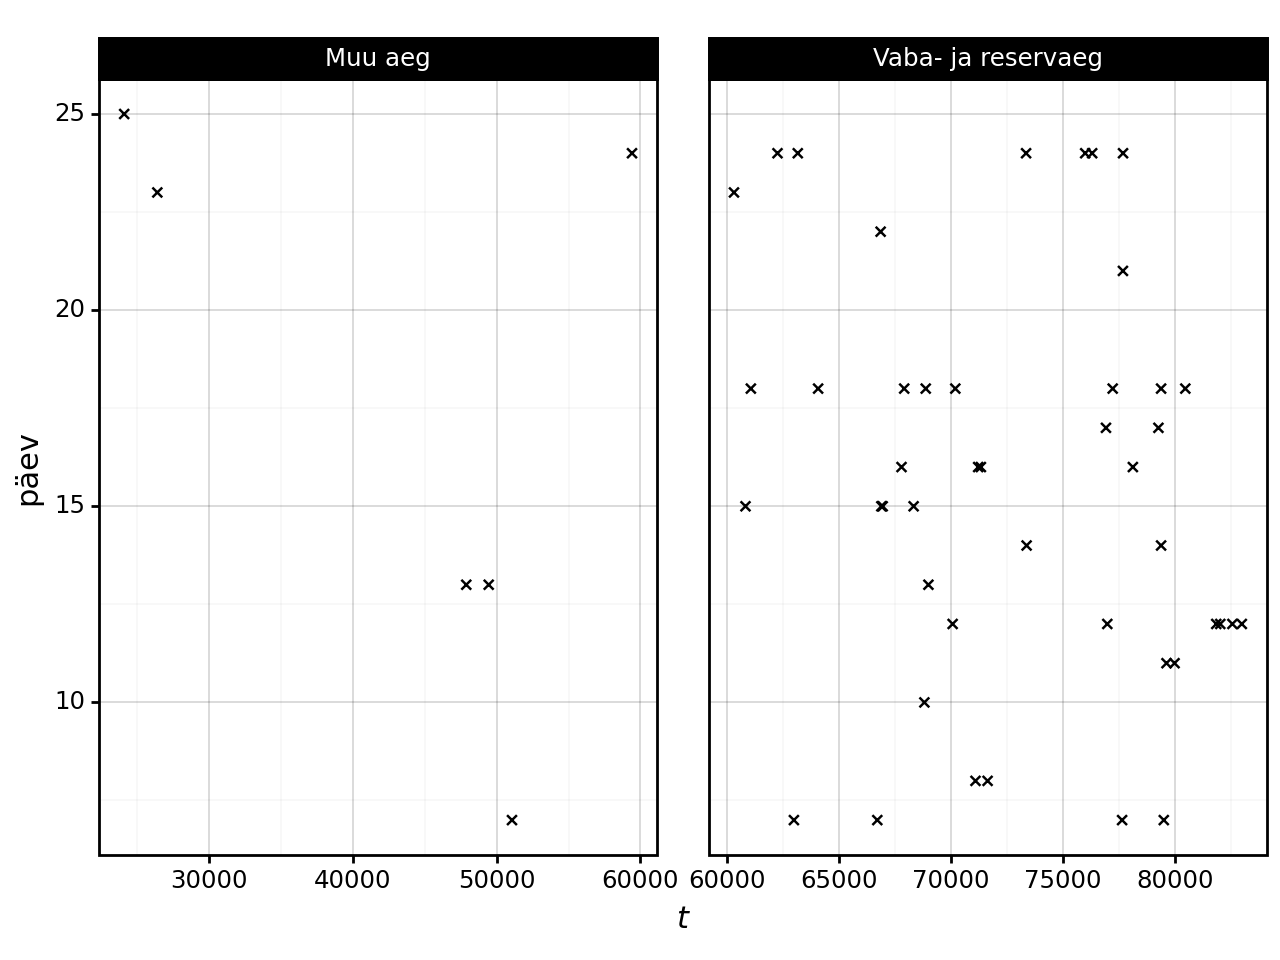

<Figure Size: (640 x 480)>

In [93]:
# tegevusajad alamjoonistena

g = ggplot(spioon_df) + facet_wrap('tegevusaeg', scales='free_x') + aes('sekund', 'päev')
g += theme_linedraw() + theme(panel_spacing=0.04)
g += labs(x='$t$', y='päev')
# g += geom_rect(xmin=74100, xmax=75300, ymin=-float('inf'), ymax=float('inf'), fill='k', alpha=0.025)  # õhtune rivistus
g += geom_point(shape='x')

# g.save('paber/spioonid_päevakaupa_eraldatud.png', dpi=100)
g

## Astmejoonis

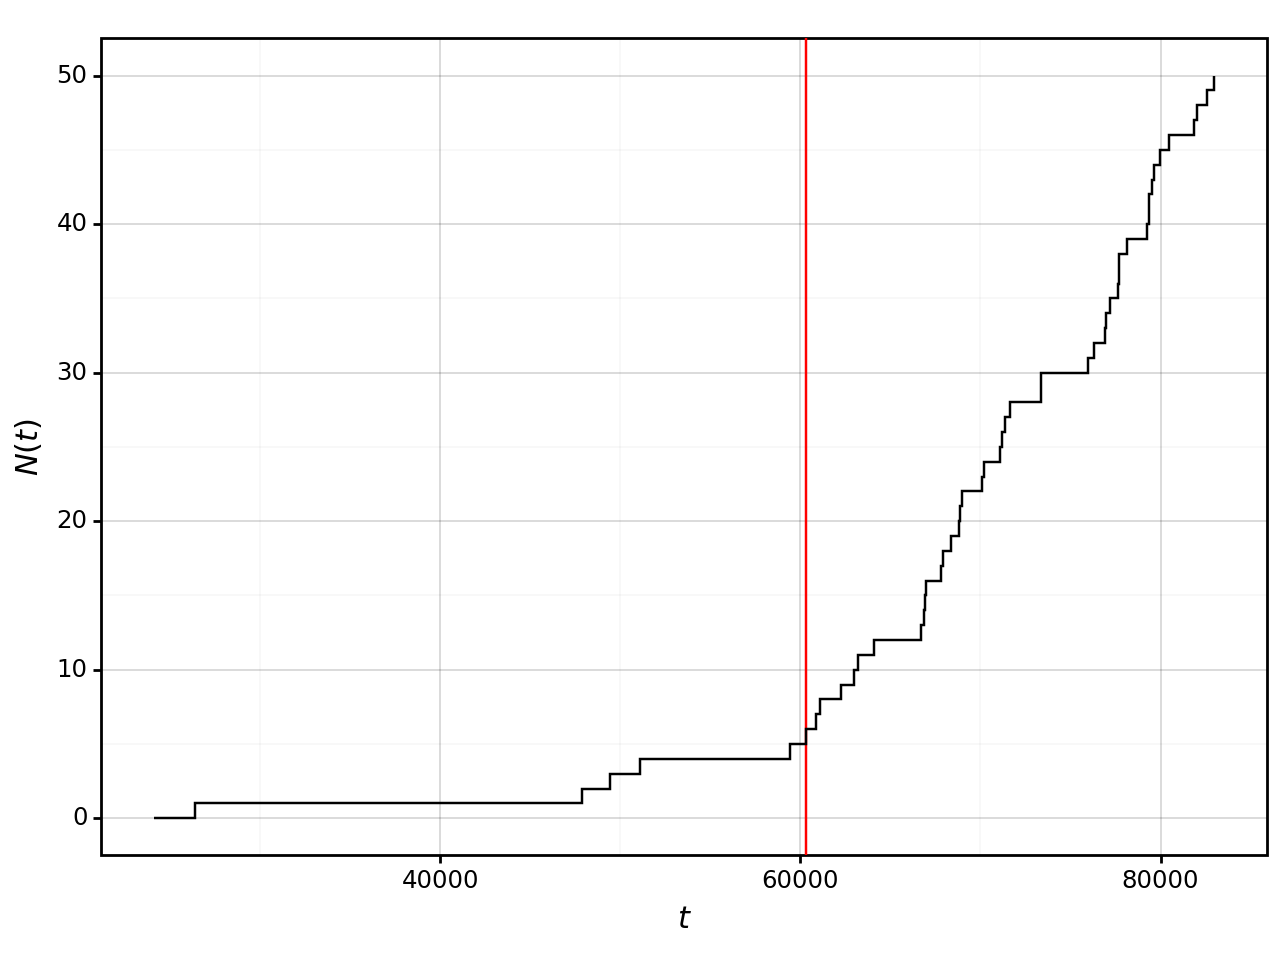

<Figure Size: (640 x 480)>

In [6]:
aste_df = spioon_df.sort_values('sekund')
aste_df['n'] = np.arange(0, aste_df.shape[0])

g = ggplot(aste_df) + theme_linedraw() + aes('sekund', 'n')
g += labs(x='$t$', y='$N(t)$')
g += geom_vline(xintercept=60300, color='r')  # reservaja algus
# g += geom_rect(xmin=74100, xmax=75300, ymin=-float('inf'), ymax=float('inf'), fill='k', alpha=0.025)  # õhtune rivistus
g += geom_step()

# g.save('paber/spioonid_astmejoonis.png', dpi=100)
g